In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, min, max, avg, countDistinct,
    lit, to_timestamp, date_format, trunc, datediff, last_day, to_date
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import DecimalType
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 3, Finished, Available, Finished)

# 1. Leitura e Análise dos Metadados

In [2]:
# Pegando a base de atrasos
df_atrasos = spark.sql("SELECT * FROM Silver.rawdata.dados_faturamento")

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 4, Finished, Available, Finished)

In [3]:
# Pegando a base de pagamentos
df_pagamentos = spark.sql("SELECT * FROM Silver.rawdata.pagamento")

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 5, Finished, Available, Finished)

In [5]:
df_atrasos.printSchema()

StatementMeta(, , -1, Waiting, , Waiting)

root
 |-- NUM_CPF: string (nullable = true)
 |-- DAT_REFERENCIA: timestamp (nullable = true)
 |-- NUM_FATURA_HASH: string (nullable = true)
 |-- NUM_ENT_SEQ_FATURA: long (nullable = true)
 |-- CONTRATO: string (nullable = true)
 |-- DW_UN_NEGOCIO: long (nullable = true)
 |-- DW_HIS_PONTO_VENDA_COMTA: long (nullable = true)
 |-- DW_NUM_CLIENTE: long (nullable = true)
 |-- DW_AREA: long (nullable = true)
 |-- DW_CICLO: long (nullable = true)
 |-- DW_TIPO_CLIENTE_CONTA: long (nullable = true)
 |-- DW_OFERTA: long (nullable = true)
 |-- DW_FAIXA_AGING_FATURA: long (nullable = true)
 |-- DW_FAIXA_AGING_DIVIDA: long (nullable = true)
 |-- DW_FAIXA_TEMPO_BASE: long (nullable = true)
 |-- DW_FAIXA_AGING_PROX_FECH: long (nullable = true)
 |-- DW_TIPO_FATURAMENTO: long (nullable = true)
 |-- COD_PLATAFORMA: string (nullable = true)
 |-- DAT_CRIACAO_REGISTRO_TRANS: timestamp (nullable = true)
 |-- DAT_ALTERACAO_REGISTRO_TRANS: timestamp (nullable = true)
 |-- DAT_CANCELAMENTO_FAT: timestamp (null

In [6]:
# Função para gerar metadados da base
def gerar_meta_dados(df):
    """
    Gera um DataFrame de metadados de um Dataframe fornecidoo.
    return: Dataframe contendo os metadados
    """
    total_rows = df.count()
    metadata = []

    for col_name, col_type in df.dtypes:
        nulos = df.filter(F.col(col_name).isNull()).count()
        cardinalidade = df.select(col_name).distinct().count()
        perct_nulos = round((nulos / total_rows) * 100, 2) if total_rows > 0 else 0

        metadata.append((
            col_name,
            col_type,
            nulos,
            perct_nulos,
            cardinalidade
        ))

    return df.sparkSession.createDataFrame(
        metadata,
        ["coluna", "tipo_de_dados", "nulos", "percent_nulos", "cardinalidade" ]
    )

StatementMeta(, , -1, Waiting, , Waiting)

In [7]:
# Visualizando os metadados da base
df_metadados = gerar_meta_dados(df_atrasos)

# Colocando em ordem decrescente correspondente ao % de nulos.
df_metadados.orderBy(F.col("percent_nulos").desc()).show(df_metadados.count(), False)

StatementMeta(, , -1, Waiting, , Waiting)

+----------------------------+-------------+--------+-------------+-------------+
|coluna                      |tipo_de_dados|nulos   |percent_nulos|cardinalidade|
+----------------------------+-------------+--------+-------------+-------------+
|DAT_CANCELAMENTO_FAT        |timestamp    |32687219|100.0        |1            |
|DAT_ALTERACAO_VCTO_FAT      |timestamp    |32599360|99.73        |761          |
|DAT_ORIGINAL_VCTO_FAT       |timestamp    |2197690 |6.72         |2318         |
|DAT_STATUS_FAT              |timestamp    |2151806 |6.58         |2824         |
|DW_FAIXA_AGING_DIVIDA       |bigint       |0       |0.0          |16           |
|NUM_ENT_SEQ_FATURA          |bigint       |0       |0.0          |1183         |
|VAL_FAT_AJUSTE              |decimal(18,4)|0       |0.0          |8581         |
|VAL_FAT_ABERTO_LIQ          |decimal(18,4)|0       |0.0          |69158        |
|VAL_FAT_BRUTO_BC            |decimal(18,4)|0       |0.0          |68671        |
|DW_HIS_PONTO_VE

In [15]:
# Visualizando os metadados da base
df_metadados = gerar_meta_dados(df_pagamentos)

# Colocando em ordem decrescente correspondente ao % de nulos.
df_metadados.orderBy(F.col("percent_nulos").desc()).show(df_metadados.count(), False)

StatementMeta(, fc31aa8d-57af-4b91-bdfa-3446c7724e9d, 15, Finished, Available, Finished)

+----------------------------+-------------+--------+-------------+-------------+
|coluna                      |tipo_de_dados|nulos   |percent_nulos|cardinalidade|
+----------------------------+-------------+--------+-------------+-------------+
|COD_DESALOCACAO_CREDITO     |string       |27948583|100.0        |1            |
|COD_NETUNO_PAGAMENTO        |string       |27948583|100.0        |1            |
|DAT_ATUALIZACAO_CREDITO     |timestamp    |27948583|100.0        |1            |
|COD_FUNDO_ATIVIDADE         |string       |27937991|99.96        |1479         |
|NUM_PARCELA_PAGAMENTO       |bigint       |27387166|97.99        |653          |
|DAT_ATUALIZACAO_ATIVIDADE   |timestamp    |26849785|96.07        |394599       |
|NUM_CONTA_ATIVIDADE         |string       |25621463|91.67        |272211       |
|DAT_ATUALIZACAO_PAGAMENTO   |timestamp    |25001438|89.46        |185328       |
|DSC_PAGAMENTO               |string       |24967432|89.33        |1959589      |
|COD_ARQUIVO_PAG

In [8]:
display(df_atrasos)

StatementMeta(, , -1, Waiting, , Waiting)

SynapseWidget(Synapse.DataFrame, 3ed83e95-edf6-4dfc-b53c-d371acaafeee)

# 2. Exploração dos Dados

In [4]:
# Remoção das colunas criadas no processo de Data Engineer
colunas_remover = ["_execution_id", "_data_inclusao", "_data_alteracao_silver"] 

df_atrasos = df_atrasos.drop(*colunas_remover)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 6, Finished, Available, Finished)

In [10]:
# Analisando quantidade de registros e CPFS
resumo = df_atrasos.agg(
    count("*").alias("qtd_registros"),
    countDistinct("NUM_CPF").alias("qtd_cpfs")
).collect()[0]

print(f"A quantidade de registros é de: {resumo.qtd_registros}")
print(f"A quantidade de CPFs Distintos é de: {resumo.qtd_cpfs}")

StatementMeta(, , -1, Waiting, , Waiting)

A quantidade de registros é de: 32687219
A quantidade de CPFs Distintos é de: 2095944


In [11]:
# Visualizando as colunas de Datas
colunas_dat = [c for c in df_atrasos.columns if c.startswith("DAT")]

df_atrasos_datas = df_atrasos.select(*colunas_dat).show(truncate=False)

StatementMeta(, , -1, Waiting, , Waiting)

+-------------------+--------------------------+----------------------------+--------------------+---------------------+----------------------+-------------------+-------------------+--------------+----------------------+----------------------+-------------------+
|DAT_REFERENCIA     |DAT_CRIACAO_REGISTRO_TRANS|DAT_ALTERACAO_REGISTRO_TRANS|DAT_CANCELAMENTO_FAT|DAT_ORIGINAL_VCTO_FAT|DAT_ALTERACAO_VCTO_FAT|DAT_CRIACAO_FAT    |DAT_VENCIMENTO_FAT |DAT_STATUS_FAT|DAT_MIN_VENCIMENTO_FAT|DAT_ATIVACAO_CONTA_CLI|DAT_CRIACAO_DW     |
+-------------------+--------------------------+----------------------------+--------------------+---------------------+----------------------+-------------------+-------------------+--------------+----------------------+----------------------+-------------------+
|2025-01-01 00:00:00|2024-12-18 04:58:01       |2024-12-18 04:58:01         |NULL                |NULL                 |NULL                  |2024-12-18 00:00:00|2025-01-06 00:00:00|NULL          |2025-01

In [12]:
# Visualizando as DATAS de DAT_REFERENCIA
df_atrasos.select("DAT_REFERENCIA").distinct().orderBy("DAT_REFERENCIA").show(truncate=False)

StatementMeta(, , -1, Waiting, , Waiting)

+-------------------+
|DAT_REFERENCIA     |
+-------------------+
|2023-10-01 00:00:00|
|2023-11-01 00:00:00|
|2023-12-01 00:00:00|
|2024-01-01 00:00:00|
|2024-02-01 00:00:00|
|2024-03-01 00:00:00|
|2024-04-01 00:00:00|
|2024-05-01 00:00:00|
|2024-06-01 00:00:00|
|2024-07-01 00:00:00|
|2024-08-01 00:00:00|
|2024-09-01 00:00:00|
|2024-10-01 00:00:00|
|2024-11-01 00:00:00|
|2024-12-01 00:00:00|
|2025-01-01 00:00:00|
|2025-02-01 00:00:00|
|2025-03-01 00:00:00|
+-------------------+



In [14]:
colunas_ind = [c for c in df_atrasos.columns if c.startswith("IND")]

df_atrasos_ind = df_atrasos.select(*colunas_ind).show(truncate=False)

StatementMeta(, fc31aa8d-57af-4b91-bdfa-3446c7724e9d, 14, Finished, Available, Finished)

+-------------------+------+-------+--------+-------+----------------+----------+
|IND_ISENCAO_COB_FAT|IND_WO|IND_PDD|IND_PCCR|IND_ACA|IND_PRIMEIRA_FAT|IND_FRAUDE|
+-------------------+------+-------+--------+-------+----------------+----------+
|-2                 |R     |N      |C       |N      |S               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |S      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2                 |R     |N      |C       |N      |N               |N         |
|-2             

## Integração do Book de Atrasos x Book de Pagamentos

In [5]:
# Criando a variável de SAFRA no book de Atrasos
df_atrasos_safra = (
    df_atrasos
    .withColumn(
        "SAFRA",
        date_format(col("DAT_REFERENCIA"), "yyyyMM")
    )
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 7, Finished, Available, Finished)

In [11]:
# Agrupamento do book de Atrasos por NUM_CPF e SAFRA
atrasos_safra = (
    df_atrasos_safra
    .groupBy("NUM_CPF", "SAFRA", "CONTRATO")
    .agg(
        F.count("*").alias("QT_FATURAS"),
        F.sum("VAL_FAT_ABERTO").alias("VAL_TOTAL_ABERTO"),
        F.sum("DW_FAIXA_AGING_FATURA").alias("MAX_FAIXA_AGING"),
        F.min("DAT_VENCIMENTO_FAT").alias("MENOR_VCTO"),
        F.max("DAT_VENCIMENTO_FAT").alias("MAIOR_VCTO"),
        F.max(F.when(col("IND_PRIMEIRA_FAT") == "S", 1).otherwise(0)).alias("FLG_PRIMEIRA_FAT"), # 1 = PRIMEIRA_FATURA, 0 = NÃO É
        F.first("COD_PLATAFORMA", ignorenulls=True).alias("COD_PLATAFORMA") # VAI INFORMAR A PLATAFORMA COM DOMINÂNCIA NA SAFRA
    )
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 13, Finished, Available, Finished)

In [20]:
print("Linhas do book de atrasos: ", df_atrasos.count())
print("Linhas Atrasos: ", atrasos_safra.count())
print(atrasos_safra.select("NUM_CPF", "SAFRA", "CONTRATO").distinct().count())

StatementMeta(, 16647dbc-5082-46a7-9ded-9b841a0db77a, 22, Finished, Available, Finished)

Linhas do book de atrasos:  32687219
Linhas Atrasos:  18164503
18164503


In [6]:
# Criando a variável de SAFRAS no book de Pagamentos
df_pagamentos = df_pagamentos.withColumn(
    "SAFRA",
    date_format(col("DAT_STATUS_FATURA"), "yyyyMM")
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 8, Finished, Available, Finished)

In [7]:
# Fazendo o agrupamentos dos registros por CPF + SAFRA
pag_safra = (
    df_pagamentos
    .filter(F.col("IND_STATUS_FATURA") == "C")
    .groupby("NUM_CPF", "SAFRA", "CONTRATO")
    .agg(
        F.count("*").alias("QT_PAGAMENTOS"),
        F.min("DAT_STATUS_FATURA").alias("DATA_PRIM_PAG"),
        F.max("DAT_STATUS_FATURA").alias("DATA_ULTIMO_PAG"),
        F.sum("VAL_PAGAMENTO_FATURA").alias("VAL_TOTAL_PAGO")
    )
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 9, Finished, Available, Finished)

In [19]:
print(f"Quantidade de Pagamentos: ", df_pagamentos.count())
print(f"Quantidade de Pagamento após o agrupamento: ", pag_safra.count())

StatementMeta(, 16647dbc-5082-46a7-9ded-9b841a0db77a, 21, Finished, Available, Finished)

Quantidade de Pagamentos:  27948583
Quantidade de Pagamento após o agrupamento:  14746791


In [12]:
# Left Join entre Atrasos e Pagamentos
df_book_consolidado = (
    atrasos_safra
    .join(
        pag_safra,
        on=["NUM_CPF", "SAFRA", "CONTRATO"],
        how="left"
    )
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 14, Finished, Available, Finished)

In [23]:
# Validando os Agrupamentos e o JOIN
print(df_book_consolidado.count())
print(df_book_consolidado.select("NUM_CPF", "SAFRA", "CONTRATO").distinct().count())

# VALIDADO. OK

StatementMeta(, 16647dbc-5082-46a7-9ded-9b841a0db77a, 25, Finished, Available, Finished)

18164503
18164503


In [24]:
display(df_book_consolidado)

StatementMeta(, 16647dbc-5082-46a7-9ded-9b841a0db77a, 26, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b7f5ce63-db94-44ca-b197-c7e25b6d841d)

# 3. Análise dos Dados

## Análises de Pagamentos x Atrasos

### Análise da Quantidade de Clientes que Pagaram x Não Pagaram por PLATAFORMA

In [14]:
# Criando FLAG de clientes que PAGARAM e NÃO PAGARAM.
book = df_book_consolidado.withColumn(
    "FLG_PAGOU",
    F.when(
        (F.col("QT_PAGAMENTOS") > 0) | (F.col("QT_PAGAMENTOS").isNotNull()), 1
    ).otherwise(0)
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 16, Finished, Available, Finished)

In [11]:
display(book)

StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 12, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 83f2a9e6-3d2b-41f3-b52e-f68590e3f5c0)

In [25]:
# Filtrando as Plataformas com maior quantidade de registros: AutoControle - POS-PAG, PRE-PAG e registrando os demais como OUTROS.
plataformas_validas = ["AUTOC", "POSPG", "-2"]

base_analitica = book.withColumn(
    "PLATAFORMA_AGRUPADA",
    F.when(F.col("COD_PLATAFORMA").isin(plataformas_validas),
        F.col("COD_PLATAFORMA"))
    .otherwise("OUTROS")
)

StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 26, Finished, Available, Finished)

In [37]:
# Convertendo em Pandas
pdf = (
    base_analitica
    .select(
        "PLATAFORMA_AGRUPADA",
        "FLG_PAGOU"
    )
    .toPandas()
)

StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 38, Finished, Available, Finished)

In [38]:
# Tabela Analítica em Pandas
agg = (
    pdf
    .groupby(["PLATAFORMA_AGRUPADA", "FLG_PAGOU"])
    .size()
    .reset_index(name="QTD_CLIENTES")
)

pivot = agg.pivot(
    index="PLATAFORMA_AGRUPADA",
    columns="FLG_PAGOU",
    values="QTD_CLIENTES"
).fillna(0)

pivot.columns = ["NAO_PAGOU", "PAGOU"]
pivot["TOTAL"] = pivot["NAO_PAGOU"] + pivot["PAGOU"]
pivot["TX_INADIMPLENCIA"] = pivot["NAO_PAGOU"] / pivot["TOTAL"]

pivot


StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 39, Finished, Available, Finished)

,NAO_PAGOU,PAGOU,TOTAL,TX_INADIMPLENCIA
PLATAFORMA_AGRUPADA,,,,
-2,392398,562955,955353,0.410736
AUTOC,3703834,8684780,12388614,0.298971
OUTROS,518771,208984,727755,0.712837
POSPG,927293,3165488,4092781,0.226568


StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 40, Finished, Available, Finished)

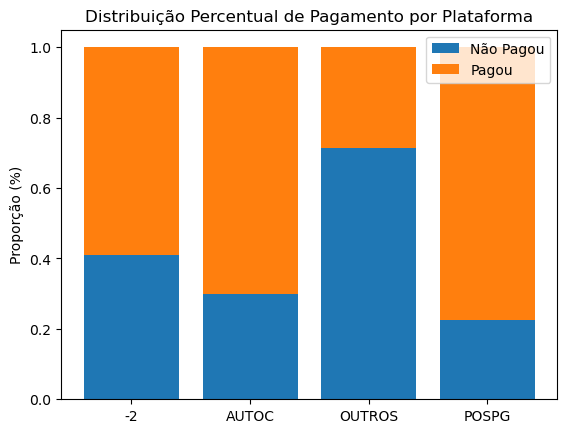

In [39]:
# Gerando gráfico de Barra empilhada (PAGOU X NÃO PAGOU)

plt.figure()

plt.bar(
    pivot.index,
    pivot["NAO_PAGOU"] / pivot["TOTAL"],
    label="Não Pagou"
)

plt.bar(
    pivot.index,
    pivot["PAGOU"] / pivot["TOTAL"],
    bottom=pivot["NAO_PAGOU"] / pivot["TOTAL"],
    label="Pagou"
)

plt.ylabel("Proporção (%)")
plt.title("Distribuição Percentual de Pagamento por Plataforma")
plt.legend()
plt.show()


StatementMeta(, b7699502-fdb2-4bb4-bdf2-7ff564692a44, 41, Finished, Available, Finished)

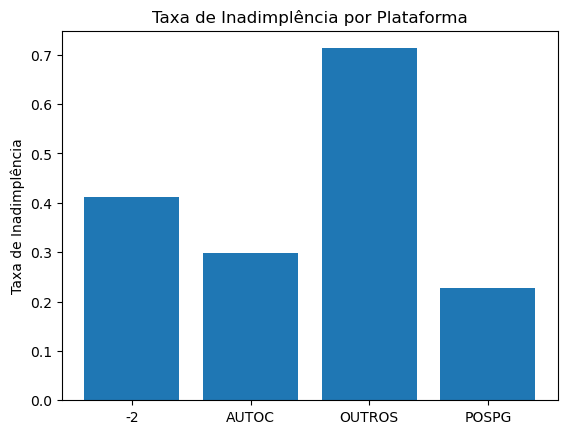

In [40]:
# Barra única com TAXA DE INADIMPLÊNCIA

plt.figure()

plt.bar(
    pivot.index,
    pivot["TX_INADIMPLENCIA"]
)

plt.ylabel("Taxa de Inadimplência")
plt.title("Taxa de Inadimplência por Plataforma")
plt.show()


### Análise de Inadimplência por Plataforma

Nesta etapa, analisamos a distribuição percentual de pagamento e não pagamento por plataforma, considerando a **flag FLG_PAGOU (0 = não pagou, 1 = pagou)**.
As plataformas foram agrupadas em **AUTOC, POSPG, -2 e OUTROS**, para garantir robustez estatística e facilitar a interpretação.

**Principais insights:**

- **AUTOC** apresenta o melhor desempenho de pagamento, com aproximadamente 70% dos registros pagos, indicando menor nível relativo de inadimplência.

- **POSPG** mostra um comportamento intermediário, com cerca de 60% de pagamentos, sugerindo maior risco quando comparado ao **AUTOC**.

- A plataforma **-2** possui um equilíbrio mais próximo entre pagamentos e não pagamentos, indicando atenção para possíveis regras de negócio específicas.

O grupo **OUTROS** concentra a maior taxa de não pagamento, ultrapassando 70%, _porém com menor volume de dados — o que reforça a decisão de tratá-lo de forma agregada_.

**Conclusão:**
A plataforma é um forte fator discriminante de inadimplência. **AUTOC** tende a apresentar menor risco, enquanto **POSPG, -2** e principalmente **OUTROS** demandam análises mais aprofundadas e possíveis estratégias específicas de mitigação de risco.


### Análise de Quantidade de Dias de Atraso por SAFRA

In [15]:
safras = ["202410", "202411", "202412", "202501", "202502", "202503"]

base_atrasos = (
    book
    .filter(F.col("SAFRA").isin(safras))    # Somente as Safras selecionadas
    .filter(F.col("FLG_PAGOU") == 1) # Somente clientes que pagaram
    # Cálculo de dias em atraso
    .withColumn(
        "DIAS_ATRASO",
        F.when(
            F.datediff(F.col("DATA_PRIM_PAG"), F.col("MENOR_VCTO")) > 0,
            F.datediff(F.col("DATA_PRIM_PAG"), F.col("MENOR_VCTO"))
        ).otherwise(0)
    )
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 17, Finished, Available, Finished)

In [16]:
base_atrasos.select("DIAS_ATRASO").summary().show()

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 18, Finished, Available, Finished)

+-------+------------------+
|summary|       DIAS_ATRASO|
+-------+------------------+
|  count|           5854532|
|   mean| 12.36217890687078|
| stddev|32.724335885810035|
|    min|                 0|
|    25%|                 0|
|    50%|                 1|
|    75%|                16|
|    max|              4853|
+-------+------------------+



In [17]:
# Transformando em Pandas
pdf_atraso = (
    base_atrasos
    .select("SAFRA", "DIAS_ATRASO")
    .toPandas()
)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 19, Finished, Available, Finished)

StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 21, Finished, Available, Finished)

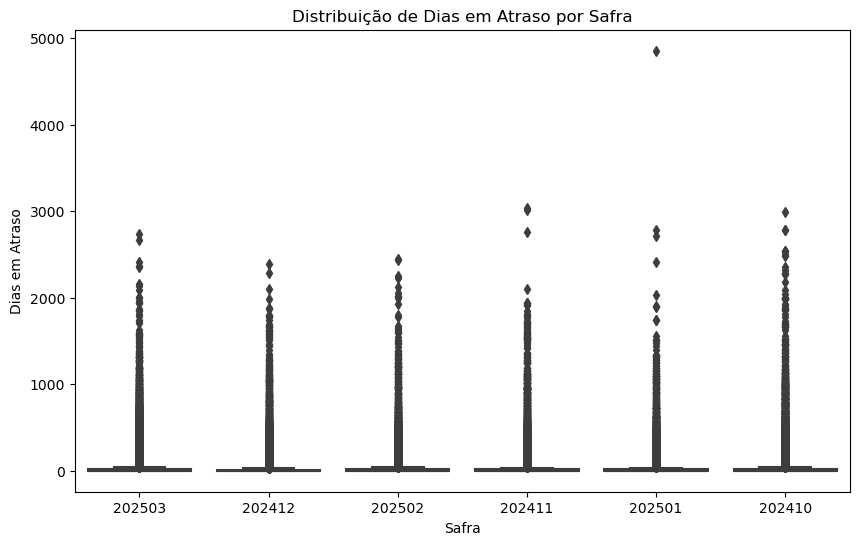

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=pdf_atraso,
    x="SAFRA",
    y="DIAS_ATRASO"
)

plt.title("Distribuição de Dias em Atraso por Safra")
plt.xlabel("Safra")
plt.ylabel("Dias em Atraso")
plt.show()


StatementMeta(, 3753eec0-cb62-4279-9b40-280d1ab5e063, 26, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_ol

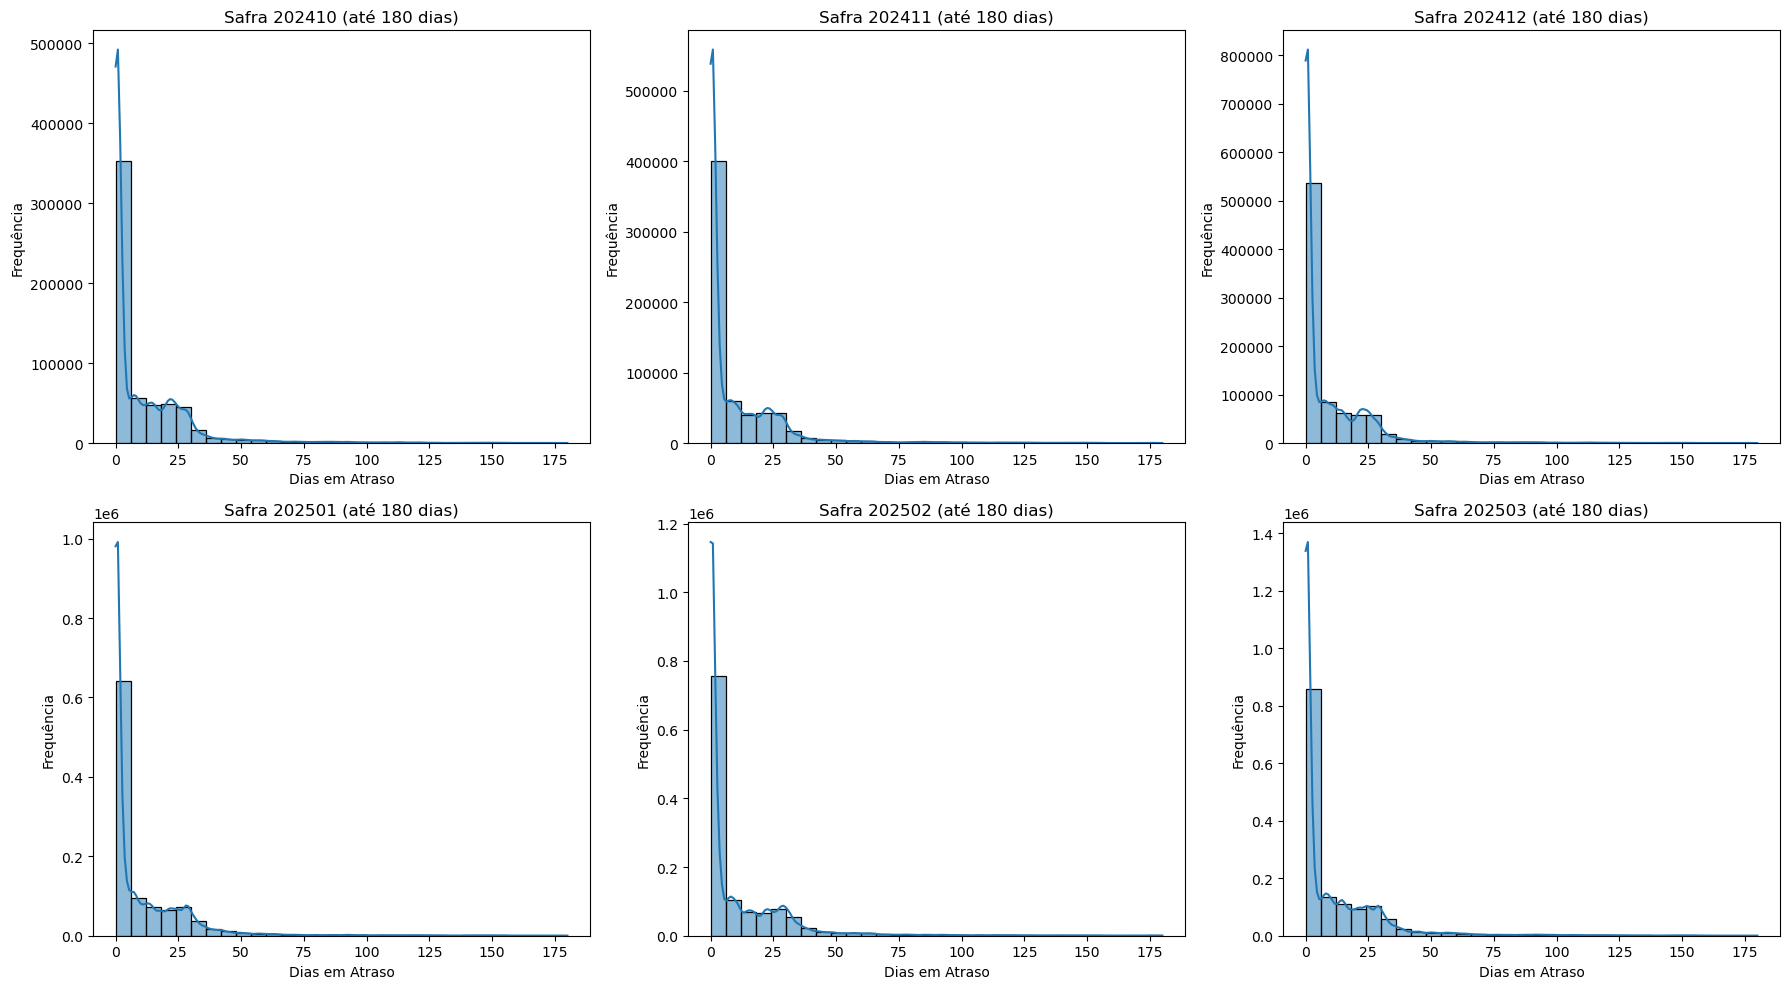

In [24]:
n_cols = 3
n_rows = math.ceil(len(safras) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, safra in enumerate(safras):
    
    dados_safra = pdf_atraso[
        (pdf_atraso["SAFRA"] == safra) &
        (pdf_atraso["DIAS_ATRASO"] <= 180)
    ]
    
    sns.histplot(
        data=dados_safra,
        x="DIAS_ATRASO",
        bins=30,
        kde=True,
        ax=axes[i]
    )
    
    axes[i].set_title(f"Safra {safra} (até 180 dias)")
    axes[i].set_xlabel("Dias em Atraso")
    axes[i].set_ylabel("Frequência")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Análise de Dias em Atraso por Safra

Nesta etapa, foi analisada a quantidade de dias em atraso no pagamento das faturas, considerando apenas pagamentos efetivamente realizados (IND_STATUS_FATURA = 'C').

**O cálculo de dias em atraso foi definido como a diferença entre:**

- Data de pagamento (DAT_STATUS_FATURA – base de pagamentos)

- Data de vencimento (DAT_VENCIMENTO_FAT – base de atrasos)

A análise foi segmentada pelas safras:
202410, 202411, 202412, 202501, 202502 e 202503.

🔹 **Distribuição Geral dos Dias em Atraso**

A distribuição geral dos dias em atraso apresenta assimetria à direita, com forte concentração de pagamentos realizados nos primeiros dias após o vencimento e uma cauda longa de pagamentos realizados com atrasos elevados.

Esse comportamento indica que:

- A maioria dos clientes realiza o pagamento com pouco atraso

- Existe uma minoria de clientes que paga com atrasos muito elevados, possivelmente associados a renegociações, acordos ou recuperações tardias

Para evitar que esses casos extremos comprometam a leitura do comportamento predominante, foi realizada uma análise complementar focada nos pagamentos com até 180 dias de atraso.

**🔹 Análise Individual por Safra (até 180 dias)**

Os histogramas individuais por safra evidenciam padrões consistentes e comparáveis entre os períodos analisados:

- Em todas as safras, observa-se um pico de pagamentos concentrado entre 0 e 5 dias após o vencimento

- A frequência de pagamentos cai progressivamente após 10–15 dias

- A maioria dos pagamentos ocorre antes de 30 dias de atraso

**Ao comparar as safras:**

- Safras mais antigas (202410 e 202411) apresentam uma distribuição mais espalhada, com maior peso relativo em atrasos intermediários (15 a 40 dias)

- Safras intermediárias (202412) já demonstram redução na dispersão dos dias em atraso

- Safras mais recentes (202501, 202502 e 202503) apresentam maior concentração de pagamentos nos primeiros dias após o vencimento, com cauda mais curta

Esse padrão sugere uma melhora progressiva no comportamento de pagamento ao longo das safras, indicando pagamentos sendo realizados cada vez mais próximos da data de vencimento.

**🔹 Principais Insights**

- A maior parte dos clientes realiza o pagamento com baixo atraso

- Existe uma tendência de redução do tempo de atraso nas safras mais recentes

- O comportamento observado indica possível impacto positivo de melhorias operacionais, canais de cobrança ou perfil da carteira ao longo do tempo
